# Mathematical Foundations of Computer Graphics and Vision 2022
## Exercise 1 - Robust Estimation and Optimization

In this exercise you will apply what you learned about robust optimization, especially RANSAC and Iteratively Reweighted Least Squares (IRLS). You will implement RANSAC for circle fitting in the presence of outliers, IRLS for line fitting with $L_1$ norm, and LP for line fitting with $L_1$ and $L_\infty$ norms.

We have implemented a skeleton notebook and you have to fill out blocks marked with `TODO`. If using this notebook, please refrain from modifying the notebook outside of the `START` and `END` blocks for the coding problems, buy you may create new cells should you find that necessary. 

In [1]:
%matplotlib inline
import math
from typing import Tuple, List
import itertools
from collections import namedtuple
from datetime import datetime

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


# Defining objects to store Circle/Line objects
Circle = namedtuple("Circle", ["origin", "radius"])
Line = namedtuple("Line", ["a", "b"])

## Part 1: RANSAC for circle fitting

In [2]:
N = 100  # number of total points
D = 10  # half-domain size
R = 5  # radius of the default circle
tau = 0.1  # inlier distance threshold

### 1.1. Data generation

In [3]:
def is_circle_inlier(points: np.ndarray, circle: Circle) -> np.ndarray:
    """
    points - Nx2 array with the data points
    circle - Circle object to test against
    
    Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
    """
    is_inlier = np.ones((points.shape[0],), dtype=bool)
    
    # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
    # Use `circle.origin` and `circle.radius` to access attributes of Circle
    # START
    origin, radius = circle.origin, circle.radius
    dist = np.sqrt(np.sum((points - origin)**2, axis = 1))
    is_inlier = np.abs(dist-radius) <= tau
    # END
    
    return is_inlier


def generate_circle_points(r, n_points=N, circle: Circle = Circle((0, 0), R)) -> Tuple[np.ndarray, np.ndarray]:
    """
    r - outlier ratio
    n_points - number of points to generate
    circle - circle model for the inliers
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the respective points
    """
    n_outliers = int(n_points * r)
    n_inliers = n_points - n_outliers
    
    inliers = np.random.uniform(-D, D, (n_inliers, 2))
    outliers = np.random.uniform(-D, D, (n_outliers, 2))
    
    # TODO : Implement Task 1.1. You can use `is_circle_inlier` for that
    # START
#     thetas = 2*math.pi*np.random.rand(inliers[~mask1].shape[0])
#     noise = np.random.uniform(-tau, tau, (inliers[~mask1].shape[0]))
#     inliers[~mask1,0] = circle.origin[0] + (noise + circle.radius) * np.cos(thetas)
#     inliers[~mask1,1] = circle.origin[1] + (noise + circle.radius) * np.sin(thetas)
    mask1 = is_circle_inlier(inliers, circle)
    while inliers[~mask1].shape[0] != 0:
        inliers[~mask1] = np.random.uniform(-D, D, (inliers[~mask1].shape[0], 2))
        mask1 = is_circle_inlier(inliers, circle)
    
    mask2 = is_circle_inlier(outliers, circle)
    while outliers[mask2].shape[0] != 0:
        outliers[mask2] = np.random.uniform(-D, D, (outliers[mask2].shape[0], 2))
        mask2 = is_circle_inlier(outliers, circle)
    # END 
    return inliers, outliers

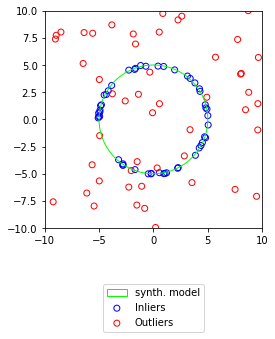

In [4]:
# Helper class to plot your results. No need to edit this, if `generate_circle_points` is implemented correctly
def plot_ransac_result(ax, inliers, outliers, ransac_model: Circle, synth_model: Circle):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')
    
    if ransac_model is not None:
        ransac_circle = plt.Circle(synth_model.origin, synth_model.radius, color='black', label='RANSAC model', fill=False)
        ax.add_patch(ransac_circle)
        
    synth_circle = plt.Circle(synth_model.origin, synth_model.radius, color='lime', label='synth. model', fill=False)
    ax.add_patch(synth_circle)
    
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")

# Plotting the ground truth inliers/outliers 
inliers, outliers = generate_circle_points(0.5)
fig, ax = plt.subplots()
plot_ransac_result(ax, inliers, outliers, None, Circle((0, 0), R))
plt.show()
plt.close(fig)

### 1.2. RANSAC

In [5]:
def fit_circle(points: np.ndarray) -> Circle:
    """
    points - 3x2 array
    
    Returns - Circle going through all the `points`
    """
    if points.shape != (3, 2):
        raise ValueError("Bad number of points")
    
    x = 0
    y = 0
    radius = 1
    
    # TODO : Compute circle origin (x, y) and radius that goes through all three `points`
    # START 
    d = 2*(points[0,0] * (points[1, 1] - points[2, 1]) + points[1,0] * (points[2, 1] - points[0, 1]) + points[2,0] * (points[0, 1] - points[1, 1]))
    x = ( (points[0,0]*points[0,0] + points[0,1]*points[0,1]) * (points[1,1] - points[2,1]) + (points[1,0]*points[1,0] + points[1,1]*points[1,1]) * (points[2,1] - points[0,1]) + (points[2,0]*points[2,0] + points[2,1]*points[2,1]) * (points[0,1] - points[1,1])) / d
    y = ( (points[0,0]*points[0,0] + points[0,1]*points[0,1]) * (points[2,0] - points[1,0]) + (points[1,0]*points[1,0] + points[1,1]*points[1,1]) * (points[0,0] - points[2,0]) + (points[2,0]*points[2,0] + points[2,1]*points[2,1]) * (points[1,0] - points[0,0])) / d
    radius = math.sqrt((points[0,0]-x)**2 + (points[0,1]-y)**2) 
    # END 
    
    return Circle((x, y), radius)

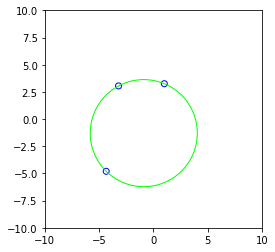

In [6]:
# Testing `fit_circle` implementation. No need to edit this
def plot_fitted_circle(points, circle: Circle):
    fig, ax = plt.subplots()
    plot_ransac_result(ax, points, points[:0], None, circle)
    ax.get_legend().remove()
    plt.show()
    plt.close(fig)
    
points = np.random.uniform(-D//2, D//2, (3, 2))
circle = fit_circle(points)

plot_fitted_circle(points, circle)

In [7]:
def get_ransac_iterations(r: float, sample_size: int, p: float) -> int:
    """
    r - outlier ratio
    sample_size - minimum data
    p - success rate
    
    Returns - number of RANSAC iterations to achieve `p` success rate 
    """
    n = 1
    
    # TODO : Compute the minimum number of RANSAC iterations necessary to achieve `p` success rate
    # START 
    n = math.ceil(math.log(1-p)/math.log(1 - (1 - r)**sample_size))
    # END 
    
    return n

In [8]:
def run_ransac(points: np.ndarray, n_iter: int) -> Tuple[np.ndarray, np.ndarray, Circle]:
    """
    points - Nx2 array with the data points
    n_iter - number of ransac iterations
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the final Circle model
    """

    n_points = points.shape[0]
    inliers = points[:0]
    outliers = points
    circle = None
    
    # TODO : Implement 1.2 - RANSAC for circle fitting
    # START
    for i in range(n_iter):
        idx = np.random.randint(n_points, size=3)
        fitted_circle = fit_circle(points[idx,:])
        mask = is_circle_inlier(points, fitted_circle)
        
        if points[mask].shape[0] > inliers.shape[0]:
            inliers = points[mask]
            outliers = points[~mask]
            circle = fitted_circle
    # END 
    
    return inliers, outliers, circle

/Users/zdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/zdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


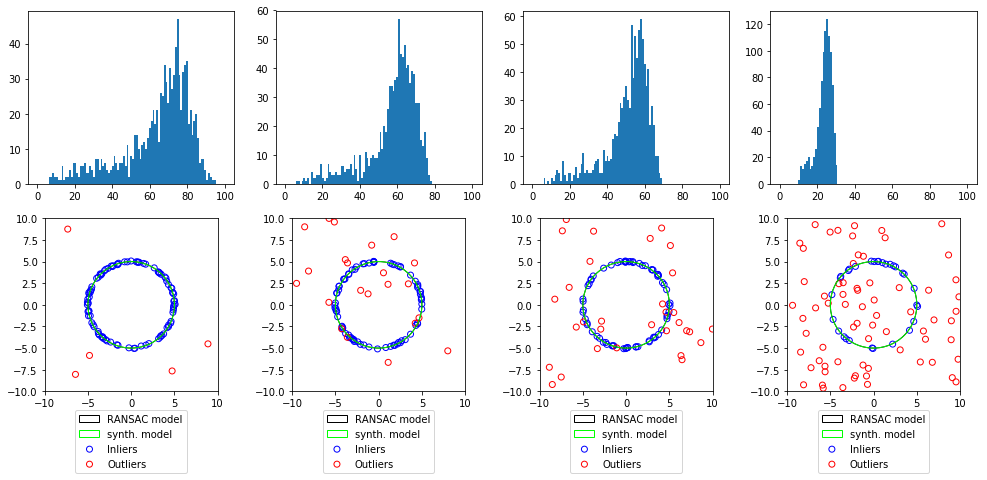

In [9]:
# Running RANSAC and populating historgrams
N_RUNS = 1000
OUTLIER_RATIOS = [0.05, 0.2, 0.3, 0.7]

fig, axes = plt.subplots(2, len(OUTLIER_RATIOS), figsize=(17, 7))

for r, (ax_hist, ax_vis) in zip(OUTLIER_RATIOS, zip(*axes)): 
    inlier_histogram = np.zeros(N_RUNS)
    
    ransac_inliers = None
    ransac_outliers = None
    circle = None
    
    # TODO : Fill `inlier_histogram` array and assign `ransac_inliers`,
    #        `ransac_outliers`, `circle`
    # START
    for i in range(N_RUNS):
        inliers, outliers = generate_circle_points(r, N)
        points = np.concatenate((inliers, outliers), 0)
        n_iter = get_ransac_iterations(r, 3, 0.99)
        temp_inliers, temp_outliers, temp_circle = run_ransac(points, n_iter)
        if ransac_inliers is None or temp_inliers.shape[0] > ransac_inliers.shape[0]:
            ransac_inliers, ransac_outliers, circle = temp_inliers, temp_outliers, temp_circle
        inlier_histogram[i] = temp_inliers.shape[0]
    # END
    
    ax_hist.hist(inlier_histogram, range=(0, N), bins=N+1)
    
    plot_ransac_result(ax_vis, ransac_inliers, ransac_outliers, circle, Circle((0, 0), R))

plt.show()
plt.close(fig)

### 1.3. Exhaustive search

In [10]:
def exhaustive_search(points: np.ndarray) -> Tuple[np.ndarray, np.ndarray, Circle]:
    """
    points - Nx2 array with the data points
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the best Circle model
    """

    n_points = points.shape[0]

    inliers = points[:0]
    outliers = points
    circle = None

    # TODO : Implement exhaustive search by trying all the combinations of minimal data points
    # START
    for sample in itertools.combinations(points, 3):
        fitted_circle = fit_circle(np.asarray(sample))
        mask = is_circle_inlier(points, fitted_circle)
        if points[mask].shape[0] > inliers.shape[0]:
            inliers = points[mask]
            outliers = points[~mask]
            circle = fitted_circle
    # END 
    
    return inliers, outliers, circle

/Users/zdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/zdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Real inliers: 16
RANSAC inliers: 15
Exhaustive search inliers: 15


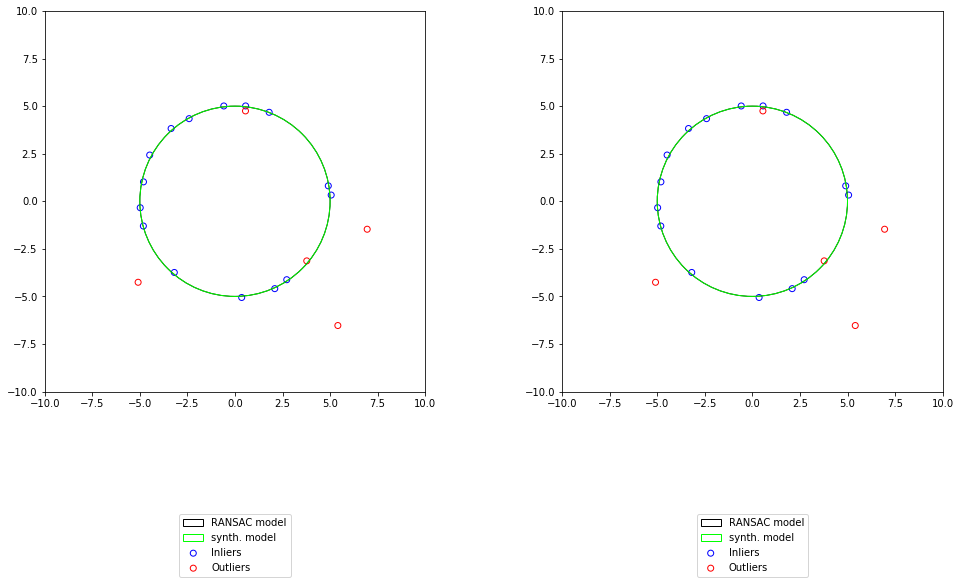

In [11]:
# Running exhaustive search. No need to edit this. Running on a reduced set of points
inliers, outliers = generate_circle_points(0.2, 20)
points = np.concatenate((inliers, outliers), 0)
n_iter = get_ransac_iterations(r, 3, 0.99)
ransac_inliers, ransac_outliers, circle = run_ransac(points, n_iter)

exhaustive_inliers, exhaustive_outliers, exhaustive_circle = exhaustive_search(points)

print(f"Real inliers: {len(inliers)}")
print(f"RANSAC inliers: {len(ransac_inliers)}")
print(f"Exhaustive search inliers: {len(exhaustive_inliers)}")

fig, axes = plt.subplots(1, 2, figsize=(17, 7))
plot_ransac_result(axes[0], ransac_inliers, ransac_outliers, circle, Circle((0, 0), R))

plot_ransac_result(axes[1], exhaustive_inliers, exhaustive_outliers, exhaustive_circle, Circle((0, 0), R))
plt.show()
plt.close(fig)

/Users/zdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/zdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


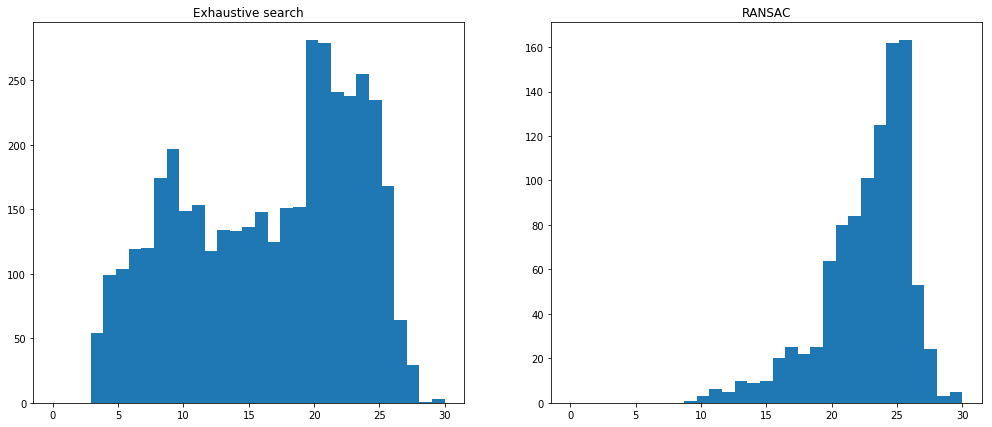

In [12]:
def exhaustive_search_histogram(inliers: np.ndarray, points: np.ndarray) -> List[int]:
    """
    inliers - Nx2 array with the true inliers from the synthetic model
    points - Nx2 array with the data points
    
    Returns - list of number of inliers for each of the samples
    """
    n_points = points.shape[0]
    
    nb_inliers_list = []
    
    # TODO : Populate `nb_inliers_list` by running exhaustive search on synthetic inliers
    #        and counting the number of found inliers in `points`
    # START
    for sample in itertools.combinations(inliers, 3):
        fitted_circle = fit_circle(np.asarray(sample))
        mask = is_circle_inlier(points, fitted_circle)
        nb_inliers_list.append(points[mask].shape[0])
    # END 
    
    return nb_inliers_list


def compare_ransac_and_exhaustive_search():
    r = 0.7
    inliers, outliers = generate_circle_points(r)
    points = np.concatenate((inliers, outliers), 0)
    
    exhaustive_histogram = exhaustive_search_histogram(inliers, points)
    
    ransac_histogram: List[int] = []
        
    # TODO : Populate `ransac_histogram` by running RANSAC 1000 times
    # START
    for i in range(1000):
        n_iter = get_ransac_iterations(r, 3, 0.99)
        ransac_inliers, _, _ = run_ransac(points, n_iter)
        ransac_histogram.append(ransac_inliers.shape[0])
    # END

    # Plotting the results
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))
    
    axes[0].hist(np.array(exhaustive_histogram), range=(0, 30), bins=31)
    axes[0].set_title('Exhaustive search')

    axes[1].hist(np.array(ransac_histogram), range=(0, 30), bins=31)
    axes[1].set_title('RANSAC')


compare_ransac_and_exhaustive_search()

### Questions and Discussion 

<b style="color:red"> Question 1: </b> How many combinations (exhaustive search) exist for $N=100$ points? 

_TODO_: There are ${100!\over3!97!} = 161700$ combinations

<b style="color:red"> Question 2: </b> What about the number of RANSAC iterations with $r=5\%$, $20\%$, $30\%$ and $70\%$? 

_TODO_:   The number of iteration is calculated using the following formula:
  $$
  N = ceil({log(1-guaranteed\ accuracy) \over log(1-(1-r)^s)})
  $$
  , where guaranteed accuracy is $99\%$, sample size $s$ is $3$.

  | r      | 5%   | 20%  | 30%  | 70%  |
  | ------ | ---- | ---- | ---- | ---- |
  | n_iter | 3    | 7    | 11   | 169  |



<b style="color:red"> Question 3: </b> What about when $N=100,000$ points?

_TODO_: There are ${100000!\over3!99997!}=166661666700000$

  | r      | 5%   | 20%  | 30%  | 70%  |
  | ------ | ---- | ---- | ---- | ---- |
  | n_iter | 3    | 7    | 11   | 169  |

<b style="color:red"> Question 4: </b> Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?

_TODO_: Yes. Because exhaustive search tries all the possibilities, and finds the optimal solution **in the range of all possible circle fitted by three points**. But it may not have the optimal solution (if the circle is not neccessarily fitted by three points)

<b style="color:red"> Question 5: </b> Does RANSAC always find close to the optimal number of inliers? Why? If not, would increasing the number of RANSAC iterations improve that?

_TODO_:   RANSAC does not guarantee the optimized solution. But as the number of iteration getting larger, the result is getting closer to the optimal solution when the outlier ratio is smaller than 0.5. Because RANSAC only finds optimized solution in randomly generated samples, it is possible that the optimal solution is not tried by the algorithm. 

  Increasing the number of iterations does improve the performance. According to the following equation:
  $$
  p = (1-(1-r)^s)^N
  $$
  , where $N$ represents the number of iterations, $p$ represents the probability that all selected samples are inliers. Increase $N$ will increase $p$. Since RANSAC keeps the optimal solution so far, increasing number of iteration will generate a result with inliers number larger or equal to the previous result.

<b style="color:red">Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.</b>

_TODO_: 

  * Number of inliers: The number of inliers of exhaustive search is always larger or equal to RANSAC. Because exhaustive search guarantees the optimal solution. 

  * Speed: RANSAC is faster in general cases. The running time of RANSAC only depends on the guaranteed accuracy and the outlier rate, but exhaustive search depends on the sample size. When sample size is large, RANSAC is faster. 

  * Number of synthesized inliers: As shown in the previous figure, the number of synthesized inliers distribute more uniformly for exhaustive search (especially when the number is small), since it tries all possible combinations. For example, if three points that are closed to each other are selected, it will generate a small circle. For RANSAC, this situation is rare since we randomly select the minimum sufficient number of samples to fit a circle. 

## Part 2: IRLS and norms for line fitting

In [13]:
N = 100  # number of total points
D = 10  # half-domain size
tau = 0.1  # inlier distance threshold

TEST_LINE = Line(1, 1)

### Data generation

In [14]:
def is_line_inlier(points: np.ndarray, line: Line) -> np.ndarray:
    """
    points - Nx2 array with the data points
    line - Line object to test against
    
    Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
    """
    is_inlier = np.ones((points.shape[0],), dtype=bool)
    
    # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
    # Use `line.a` and `line.b` to access attributes of a line
    # START
    is_inlier = np.abs(line.a * points[:, 0] + line.b - points[:, 1]) <= tau
    # END
    
    return is_inlier
    
    mask2 = is_circle_inlier(outliers, circle)
    while outliers[mask2].shape[0] != 0:
        outliers[mask2] = np.random.uniform(-D, D, (outliers[mask2].shape[0], 2))
        mask2 = is_circle_inlier(outliers, circle)
        
def generate_line_points(r: float, n_points=N, line: Line = TEST_LINE) -> np.ndarray:
    """
    r - outlier ratio
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the respective points
    """
    n_outliers = int(n_points * r)
    n_inliers = n_points - n_outliers
    
    inliers = np.random.uniform(-D, D, (n_inliers, 2))
    outliers = np.random.uniform(-D, D, (n_outliers, 2))
    
    # TODO : Implement data points generation, following similar strategy as in Part 1
    # START
#     inliers[~mask1,0] = np.random.uniform(-D, D, (inliers[~mask1].shape[0]))
#     inliers[~mask1,1] = line.a * inliers[~mask1,0] + line.b
    
#     noise = np.zeros((inliers[~mask1].shape[0], 2))
#     thetas = 2*math.pi*np.random.rand(noise.shape[0])
#     noise[:, 0] = tau * np.cos(thetas)
#     noise[:, 1] = tau * np.sin(thetas)
    
#     inliers[~mask1] += noise
    mask1 = is_line_inlier(inliers, line)
    while inliers[~mask1].shape[0] != 0:
        inliers[~mask1] = np.random.uniform(-D, D, (inliers[~mask1].shape[0], 2))
        mask1 = is_line_inlier(inliers, line)
    
    
    mask2 = is_line_inlier(outliers, line)
    while outliers[mask2].shape[0] != 0:
        outliers[mask2] = np.random.uniform(-D, D, (outliers[mask2].shape[0], 2))
        mask2 = is_line_inlier(outliers, line)
    # END 
    
    return np.concatenate((inliers, outliers), 0)

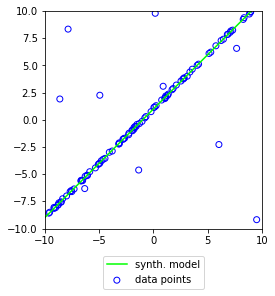

In [15]:
# Plotting the generated line, no need to change this code
def plot_line(ax, points, fitted_model: Line, synth_model: Line, title=None):
    def _plot_line(line: Line, label, color):
        x = np.linspace(-D, D, 100)
        y = line.a * x + line.b
        ax.plot(x, y, label=label, color=color)
        
    ax.scatter(points[:, 0], points[:, 1], label="data points", c='none', edgecolors='blue')
    
    if fitted_model is not None:
        _plot_line(fitted_model, 'fitted model', 'black')
        
    _plot_line(synth_model, 'synth. model', 'lime')
    
    if title is not None:
        ax.set_title(title)
        
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.3), loc="lower center")
    
points = generate_line_points(0.1)
fig, ax = plt.subplots()
plot_line(ax, points, None, Line(1, 1))
plt.show()
plt.close(fig)

In [16]:
## Implement different line fitting algorithms

def fit_line_irls_l1(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    
    line = Line(0.5, 0)
    
    # TODO : Implement line fitting with L-1 norm by using IRLS
    # START
    W = np.identity(points.shape[0])
    prev_l = np.array([line.a, line.b])
    while True:
        X = np.c_[points[:, 0], np.ones(points.shape[0])]
        y = points[: , 1]
        l = np.linalg.inv(X.T@W@X)@X.T@W@y
        if np.sqrt(np.sum((prev_l - l)**2)) <= 0.0001:
            break
        line = Line(l[0], l[1])
        prev_l = l
        W = np.diag(0.5 * np.abs(line.a * points[:, 0] + line.b - points[:, 1])**(-1))
    # END

    return line


def fit_line_lp_l1(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """   
    line = Line(0.5, 0)

    # TODO : Implement line fitting with L-1 norm by using linear programming
    # START
    A_ub = np.r_[-np.c_[points[:, 0], np.ones(points.shape[0]), np.identity(points.shape[0])], np.c_[points[:, 0], np.ones(points.shape[0]), -np.identity(points.shape[0])]]
    b_ub = np.r_[-points[:, 1], points[:, 1]]
    c = np.r_[np.zeros(2), np.ones(points.shape[0])]
    res = linprog(c, A_ub, b_ub)
    if res.success == False:
        return None
    line = Line(res.x[0], res.x[1])
    # END
    
    return line


def fit_line_lp_l_inf(points: np.ndarray) -> Line:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    line = Line(0.5, 0)
    
    # TODO : Implement line fitting with L-infinity norm by using linear programming
    # START
    A_ub = np.r_[-np.c_[points[:, 0], np.ones(points.shape[0]), np.ones(points.shape[0])], np.c_[points[:, 0], np.ones(points.shape[0]), -np.ones(points.shape[0])]]
    b_ub = np.r_[-points[:, 1], points[:, 1]]
    c = np.array([0, 0, 1])
    res = linprog(c, A_ub, b_ub)
    if res.success == False:
        return None
    line = Line(res.x[0], res.x[1])
    # END
    
    return line

IRLS L1: Line(a=1.003348789326521, b=1.0007210175472494)
LP L1: Line(a=1.0035574986259719, b=1.0012700999593442)
LP L-inf: Line(a=0.9999868362484164, b=0.9998752160533148)


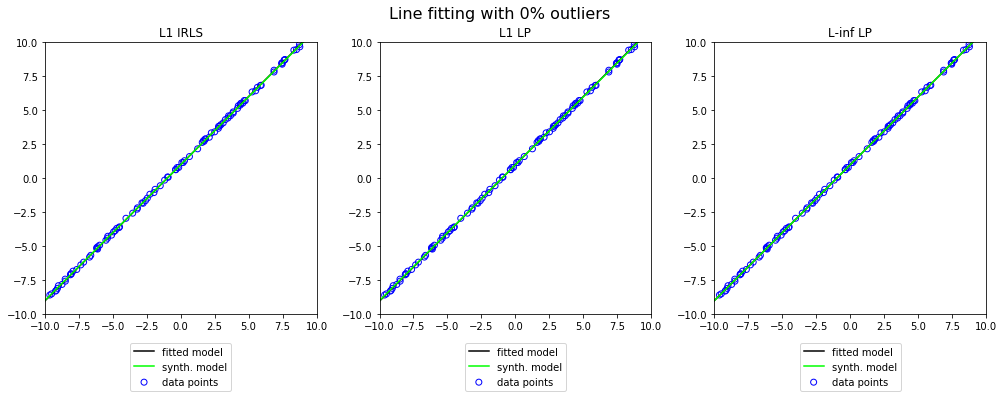

IRLS L1: Line(a=1.0022270573461622, b=0.9995293433945935)
LP L1: Line(a=1.0022841217235459, b=0.999193838313671)
LP L-inf: Line(a=1.0007811644769038, b=4.261104270635636)


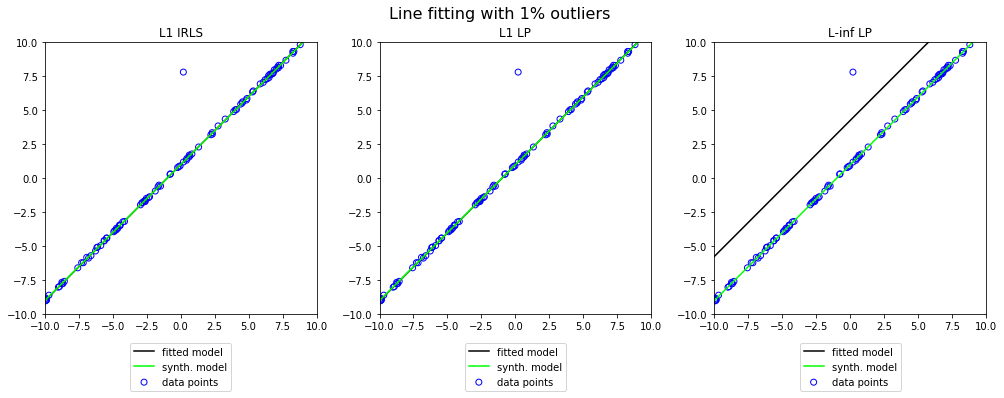

IRLS L1: Line(a=1.0021470357361817, b=1.0064459767856588)
LP L1: Line(a=1.0026150247698762, b=1.0074831081198163)
LP L-inf: Line(a=0.5651179577815916, b=0.0)


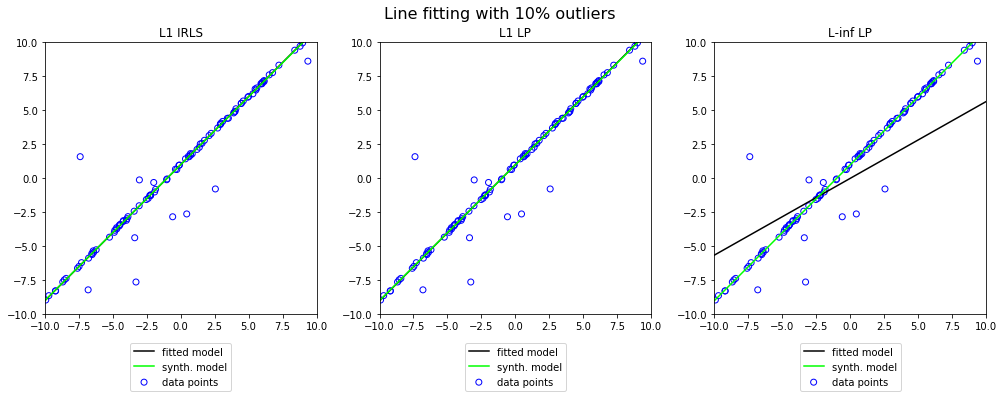

IRLS L1: Line(a=0.9885087119715488, b=1.0093976780504597)
LP L1: Line(a=0.9887553038780834, b=1.0081408804131546)
LP L-inf: Line(a=0.051688201061872684, b=0.49599199668066685)


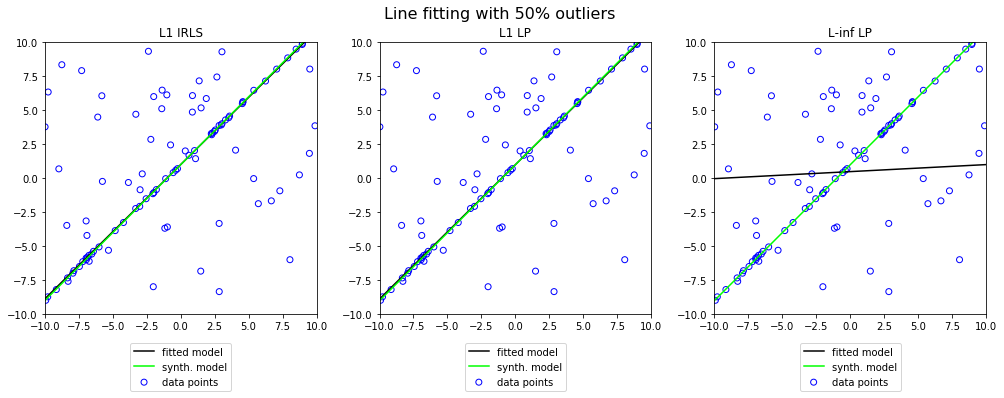

IRLS L1: Line(a=0.3396331881315227, b=0.6127317545560403)
LP L1: Line(a=0.33981643062045386, b=0.612858691793157)
LP L-inf: Line(a=0.0036057471360672576, b=0.0)


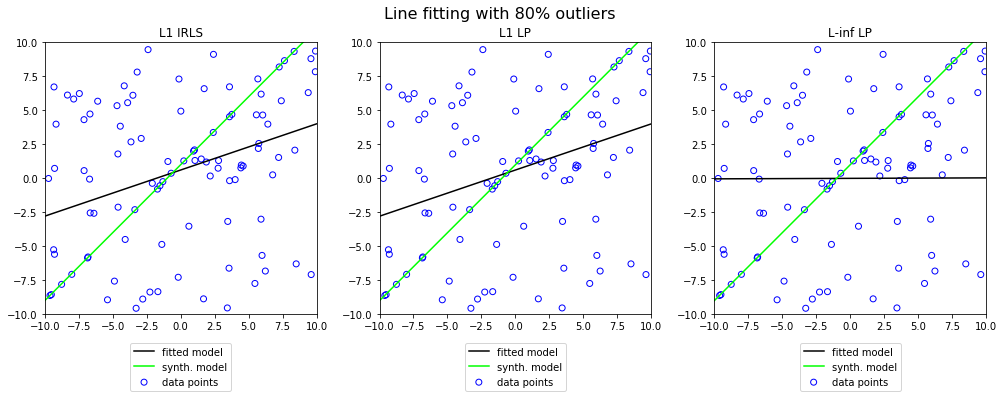

In [17]:
# Plotting the results. No need to change this code
for r in [0.0, 0.01, 0.1, 0.5, 0.8]:
    points = generate_line_points(r)
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    irls_l1_line = fit_line_irls_l1(points)
    lp_l1_line = fit_line_lp_l1(points)
    lp_l_inf_line = fit_line_lp_l_inf(points)
    
    while lp_l1_line == None or lp_l_inf_line == None:
        points = generate_line_points(r)
        irls_l1_line = fit_line_irls_l1(points)
        lp_l1_line = fit_line_lp_l1(points)
        lp_l_inf_line = fit_line_lp_l_inf(points)
    
    print(f"IRLS L1: {irls_l1_line}")
    print(f"LP L1: {lp_l1_line}")
    print(f"LP L-inf: {lp_l_inf_line}")

    plot_line(axes[0], points, irls_l1_line, Line(1, 1), title="L1 IRLS")
    plot_line(axes[1], points, lp_l1_line, Line(1, 1), title="L1 LP")
    plot_line(axes[2], points, lp_l_inf_line, Line(1, 1), title="L-inf LP")
    
    fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
    plt.show()
    plt.close(fig)

### Discussion 

<b style="color:red">Discuss the results obtained by these methods</b>

_TODO_: 
- When $r = 0$, all of the algorithms has a reliable prediction.
- When $r=0.01, 0.1, 0.5$, the first two algorithm (with $L_1$ norm) can fit the line, but the third algorithm with $L_{\infty}$ cannot make accurate prediction. This is because the infinity norm is more sensitive to the outliers.
- When $r = 0.8$, all of the algorithms cannot fit the line. Because the number of outliers is more than the number of inliers. Note that the first two algorithms have the same result since they have the same metric. 

